<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/main/XGboost_Ele_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [26]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [27]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [28]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [29]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [30]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [31]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [32]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Data Imputation

In [33]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [34]:
# Fill NaN values using the mean for each column
df.fillna(df.mean(), inplace=True)

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [35]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df['Global_active_power']*1000/60)
equation2 = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['Sub_metering_4'] = equation1 - equation2
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
date_time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [36]:
# Resampled the data
hourly_resampled = df.resample('H').mean()

# EDA

In [37]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(dataset, resample_type, title):

  # Resample the data
  df_resampled = dataset.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(30,20))
  plt.suptitle("Visualization of %s resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ %s Resampled distribution Plot **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ %s Resampled correlation Plot **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_resampled.corr(), annot=True, fmt=".2f")
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 


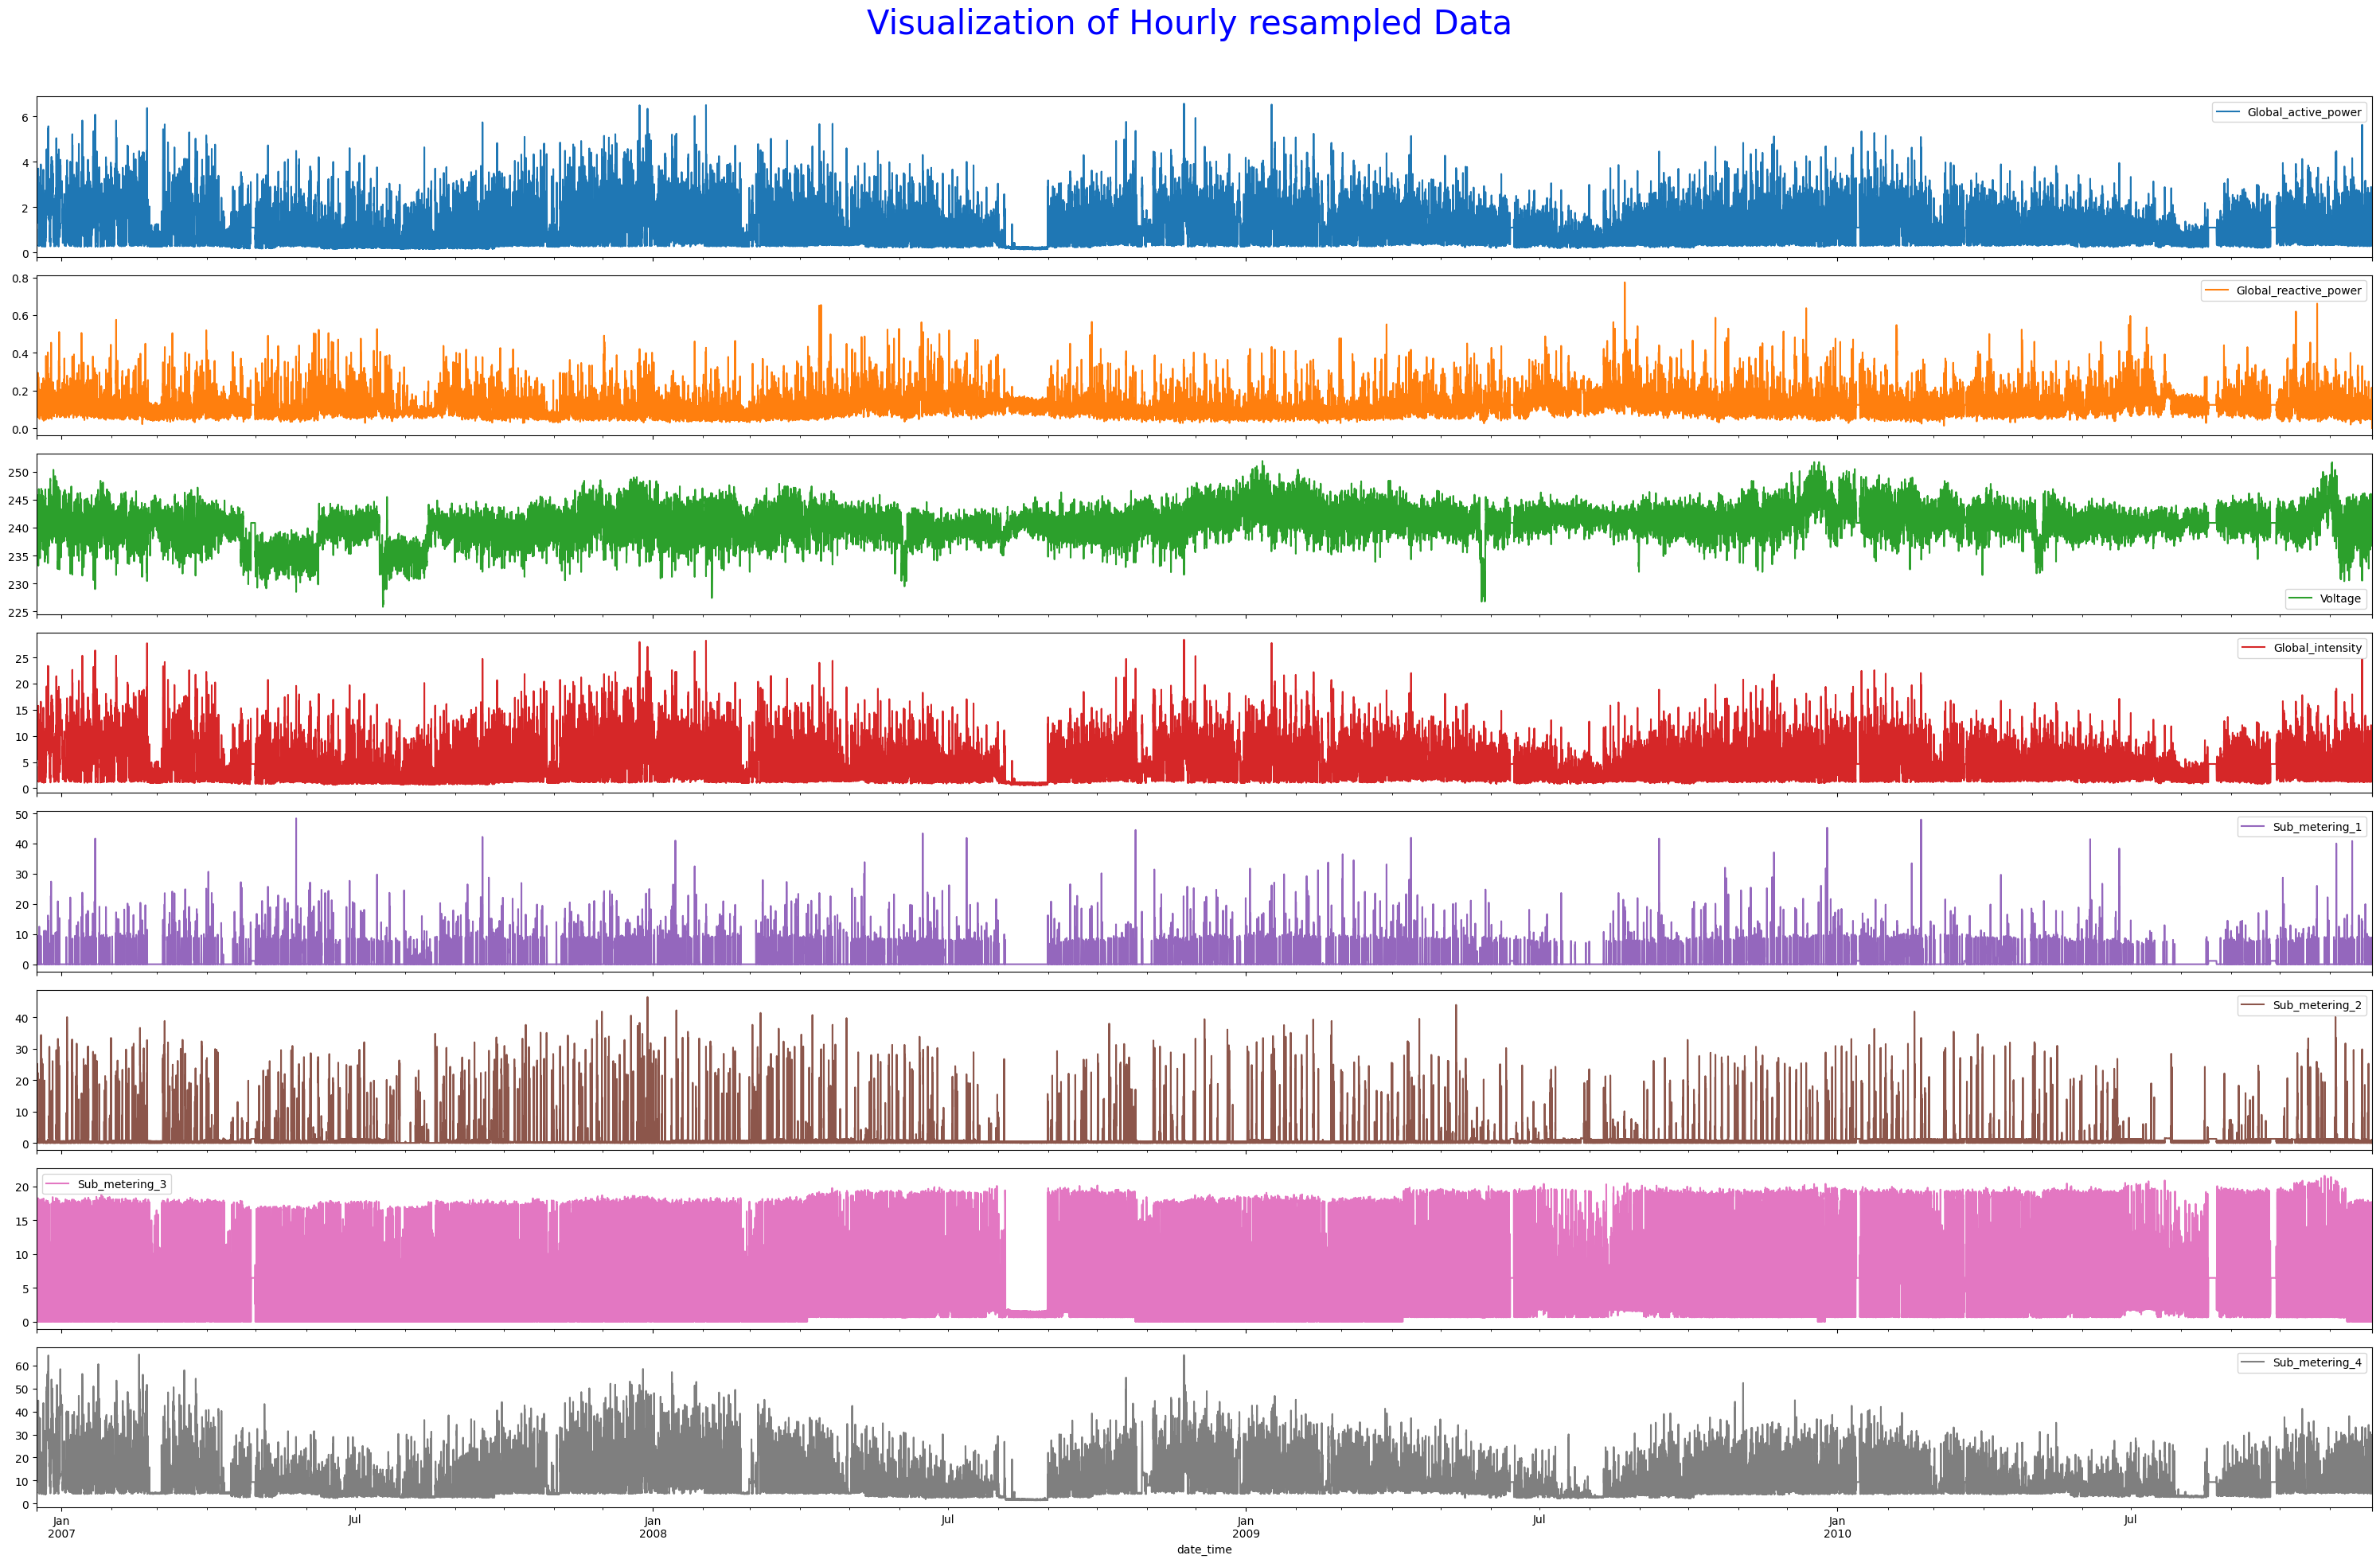

 

************************************************ Hourly Resampled distribution Plot **************************************************



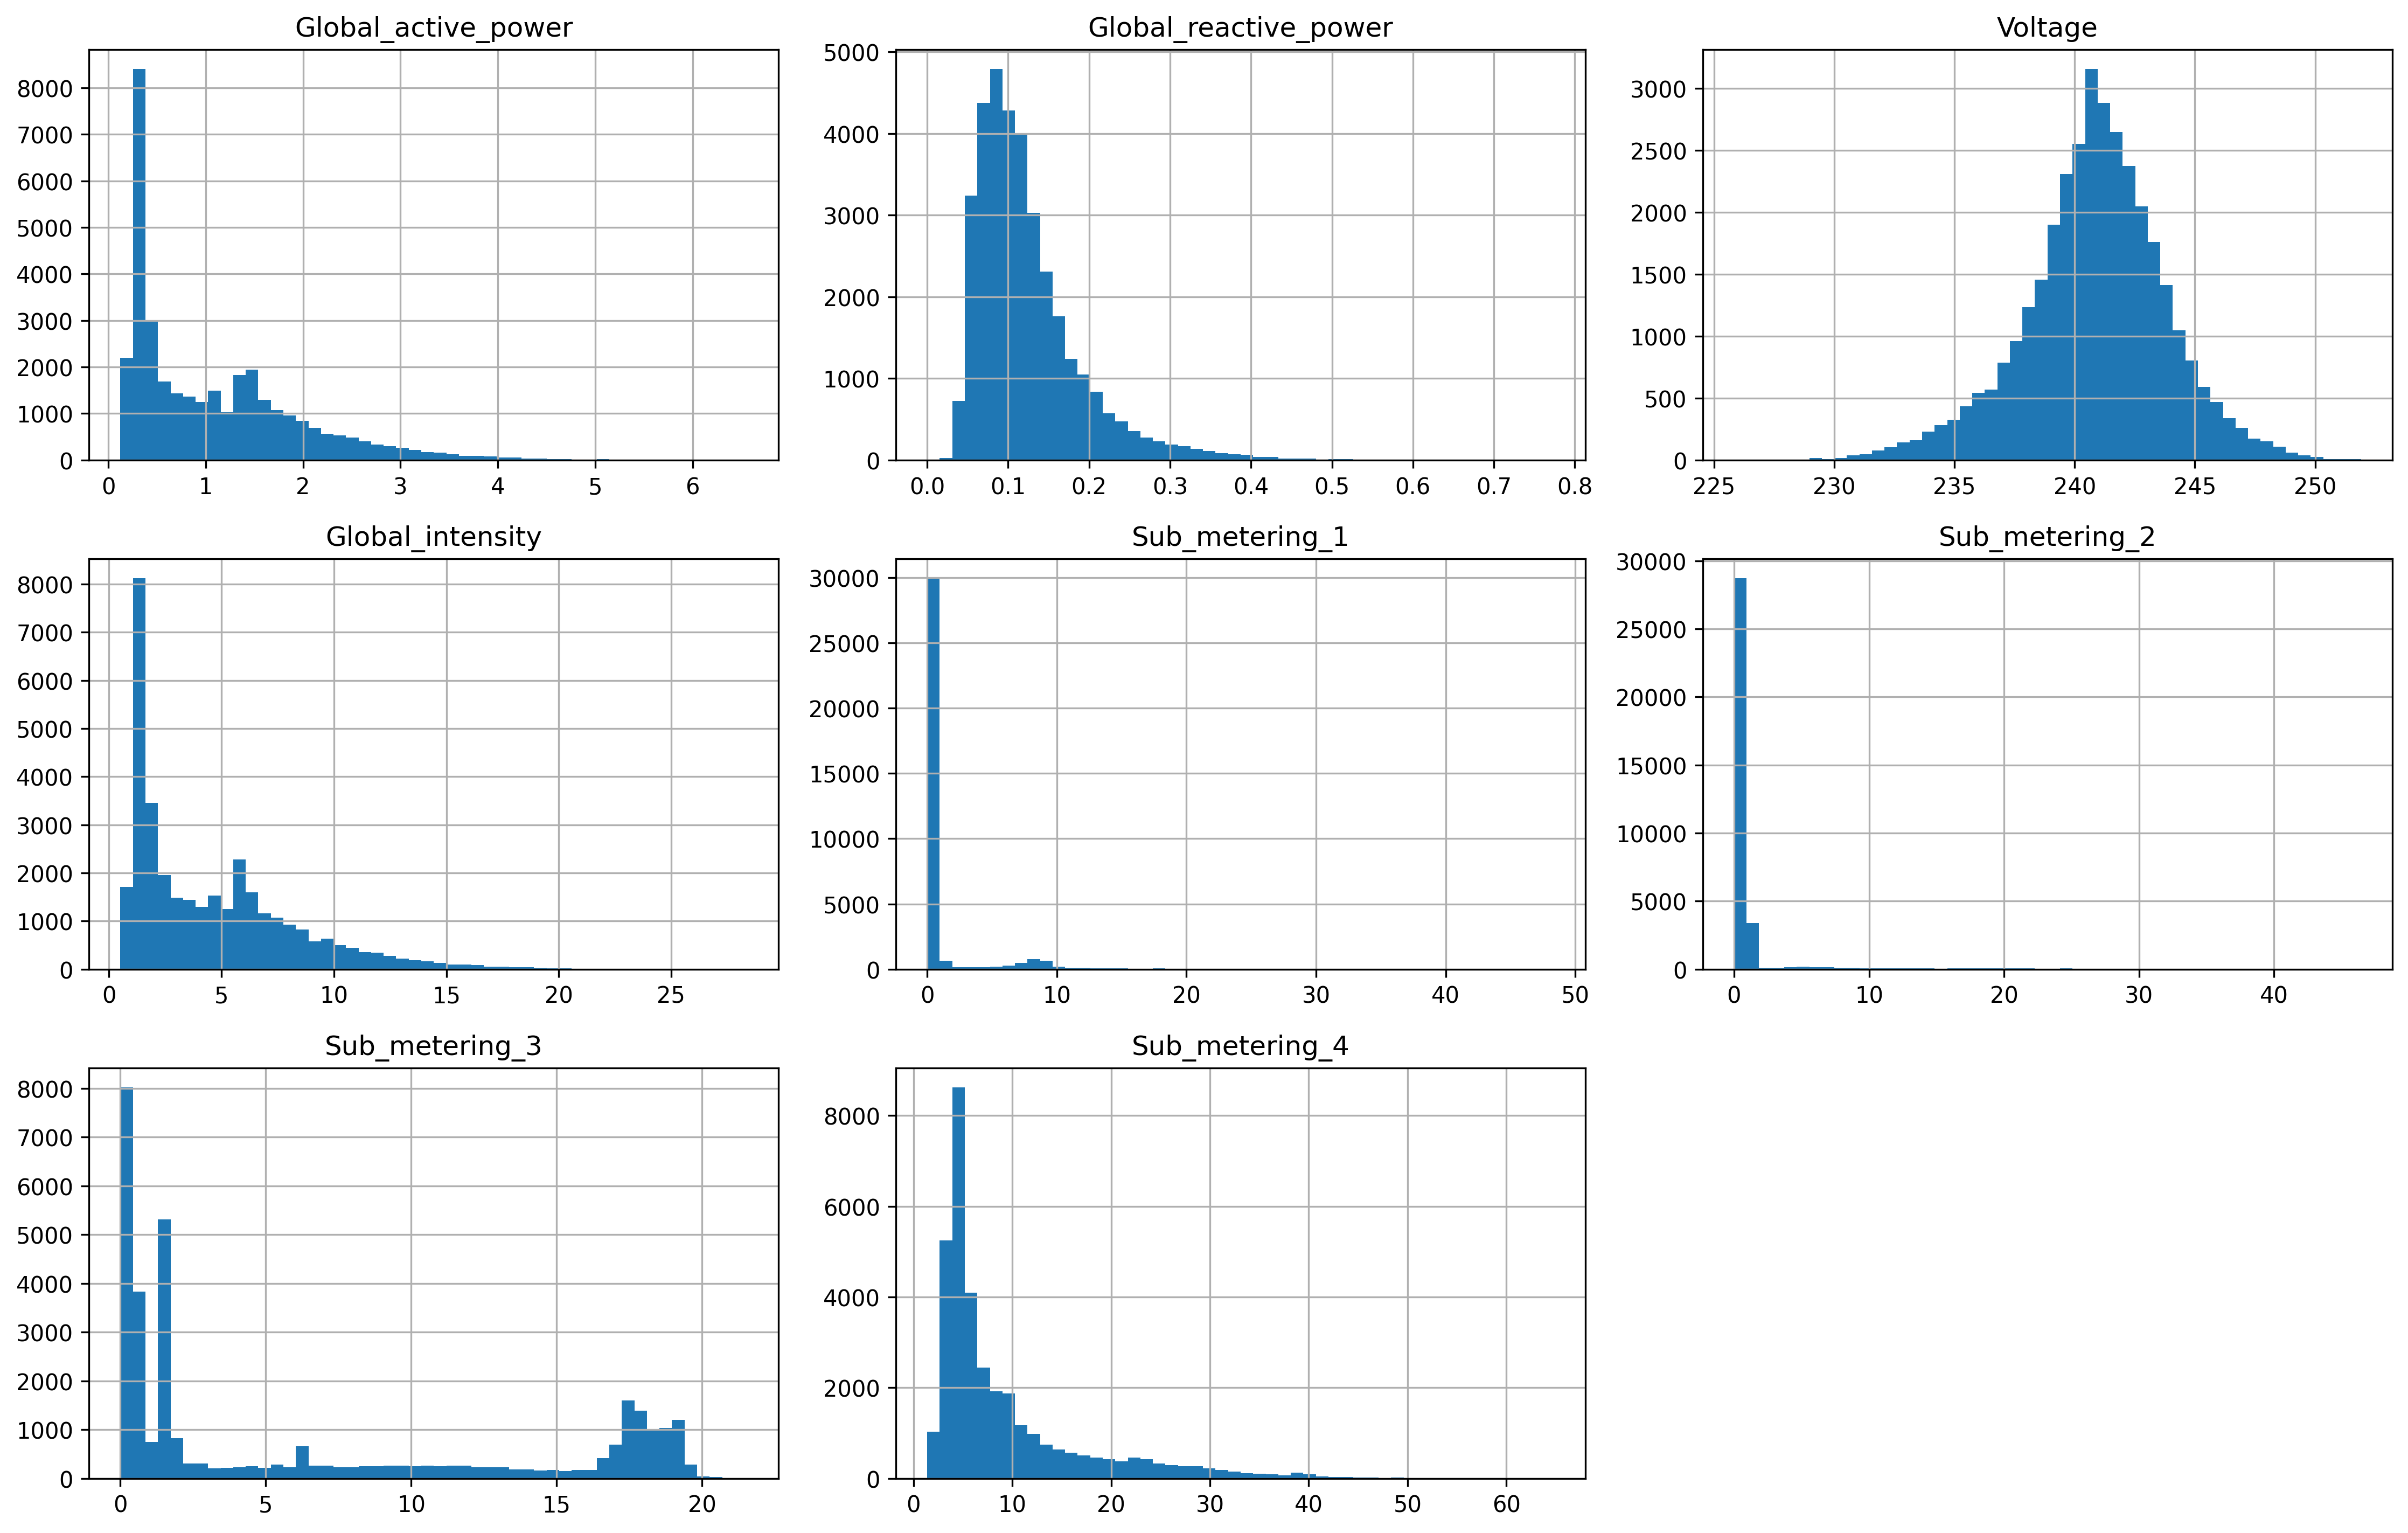

 

************************************************ Hourly Resampled correlation Plot **************************************************



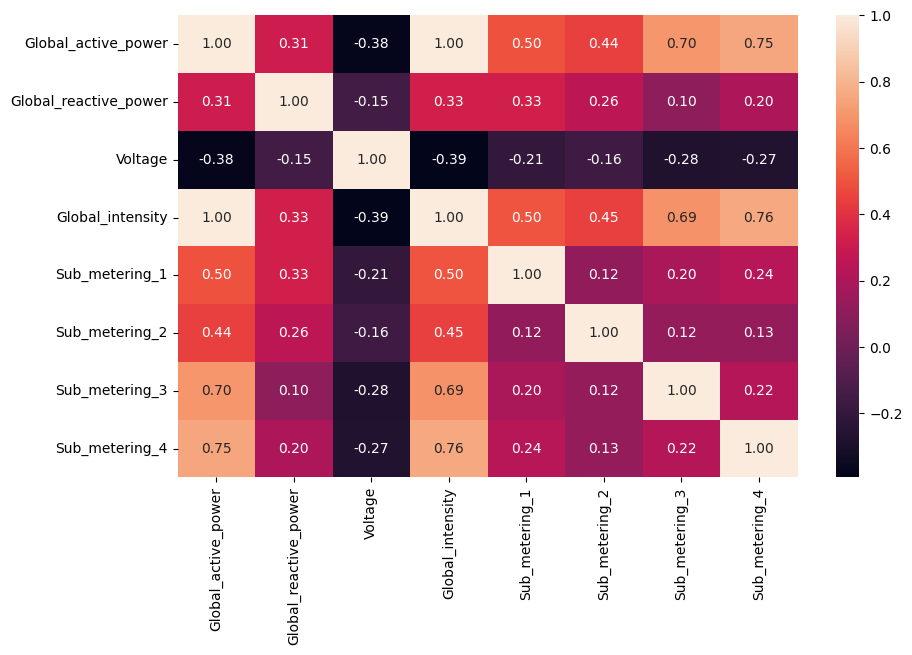

In [38]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df, "H", "Hourly")

Note:- As Global_intensity and Sub_metering_4 are highly correlated with Global_active_power so I am removing Global_intensity column

In [39]:
df1 = hourly_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)

# Feature Engineering

In [40]:
# Create new columns for hour, day, quarter, month, and year
df1['hour'] = hourly_resampled.index.hour
df1['month'] = hourly_resampled.index.month
df1['quarter'] = hourly_resampled.index.quarter
df1['year'] = hourly_resampled.index.year
df1['week_of_year'] = hourly_resampled.index.isocalendar().week
df1['day_of_week'] = hourly_resampled.index.dayofweek
df1['day_of_month'] = hourly_resampled.index.day
df1['day_of_year'] = hourly_resampled.index.dayofyear
df1.head()

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,month,quarter,year,week_of_year,day_of_week,day_of_month,day_of_year
date_time,,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,0.0,0.527778,16.861111,17,12,4,2006,50,5,16,350
2006-12-16 18:00:00,3.632200,0.080033,234.580167,0.0,6.716667,16.866667,18,12,4,2006,50,5,16,350
2006-12-16 19:00:00,3.400233,0.085233,233.232500,0.0,1.433333,16.683333,19,12,4,2006,50,5,16,350
2006-12-16 20:00:00,3.268567,0.075100,234.071500,0.0,0.000000,16.783333,20,12,4,2006,50,5,16,350
2006-12-16 21:00:00,3.056467,0.076667,237.158667,0.0,0.416667,17.216667,21,12,4,2006,50,5,16,350


In [41]:
df1.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'hour', 'month',
       'quarter', 'year', 'week_of_year', 'day_of_week', 'day_of_month',
       'day_of_year'],
      dtype='object')

# Train-Test Splitting

In [42]:
# Split the data into Train & Test Split
features = ['Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2',
            'Sub_metering_3', 'hour', 'month', 'quarter',
            'year', 'week_of_year', 'day_of_week', 'day_of_month', 'day_of_year']
target = ['Global_active_power']

train_size = int(len(df1) * 0.80)
df1_train = df1[:train_size]
df1_test = df1[train_size:]

X_train = df1_train[features]
y_train = df1_train[target]
X_test = df1_test[features]
y_test = df1_test[target]

# Check the shape of Train & Test Split
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((27671, 13), (27671, 1), (6918, 13), (6918, 1))

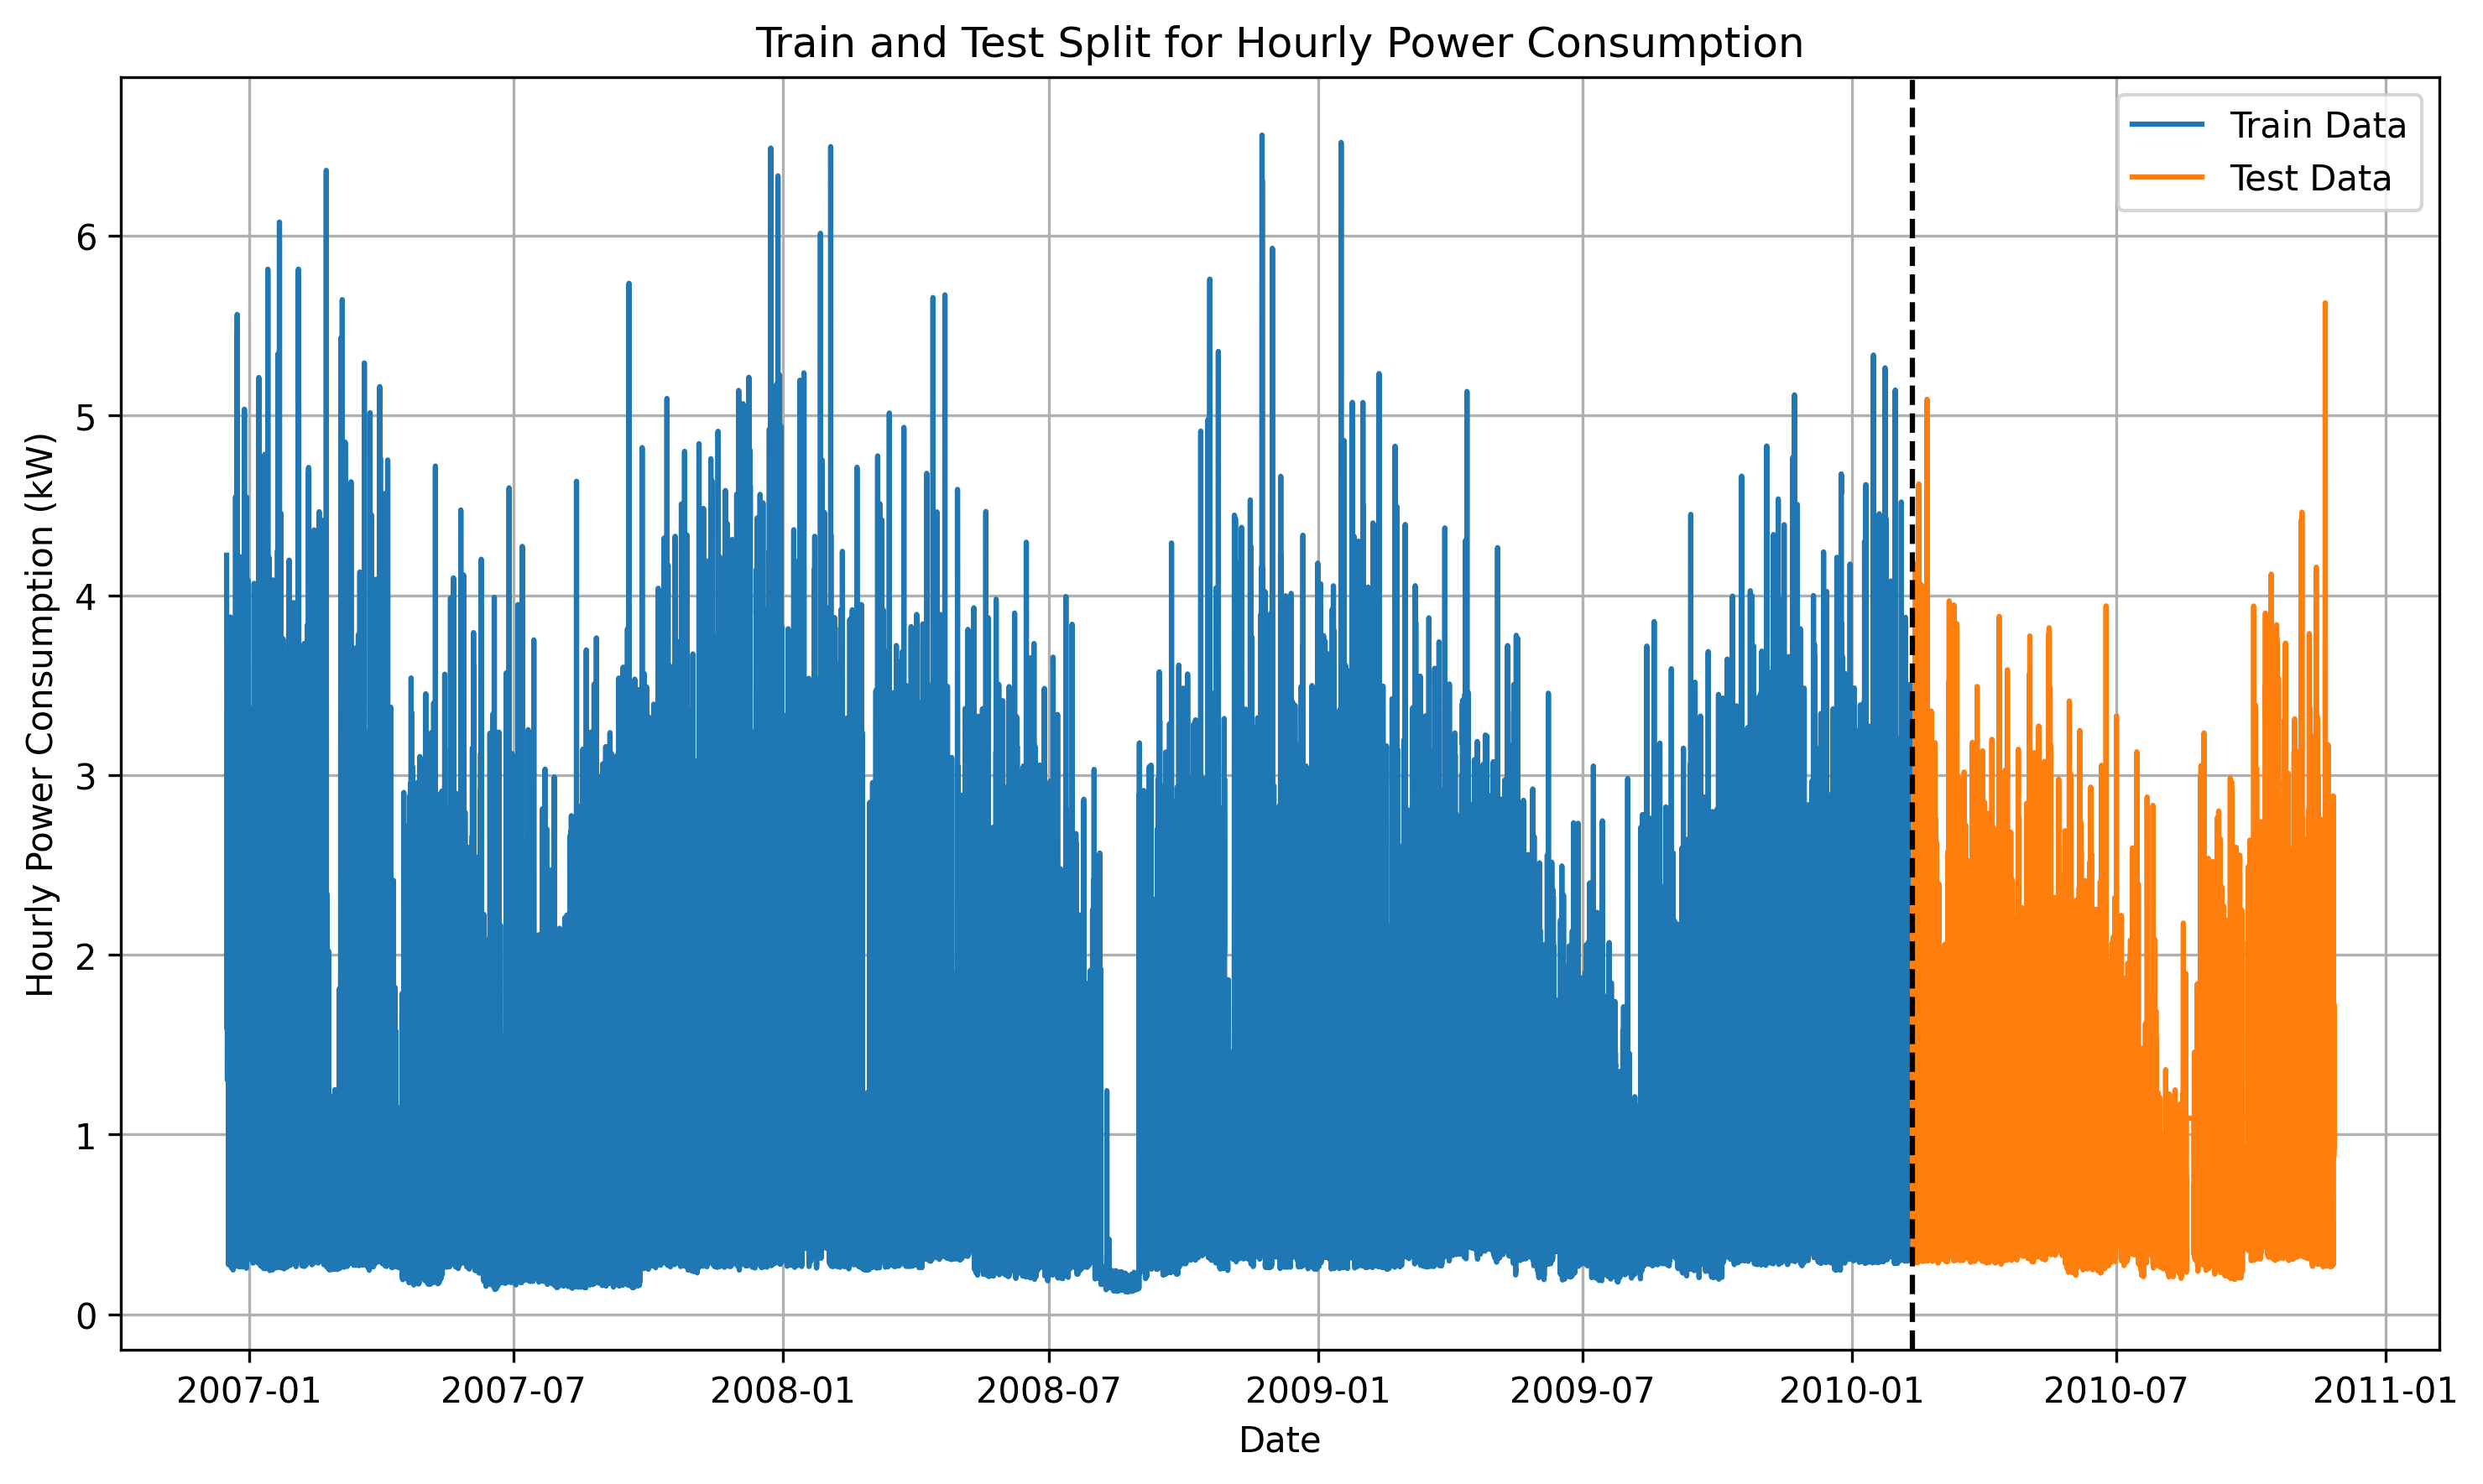

In [43]:
# Plot train & test data
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df1_train.Global_active_power, label='Train Data')
plt.plot(df1_test.Global_active_power, label='Test Data')
plt.axvline(df1_test.index[0], color='black', linestyle='--')
plt.title('Train and Test Split for Hourly Power Consumption')
plt.xlabel('Date')
plt.ylabel('Hourly Power Consumption (kW)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Xgboost model with default parameters

[0]	validation_0-rmse:0.72247	validation_1-rmse:0.54381
[99]	validation_0-rmse:0.20476	validation_1-rmse:0.27121


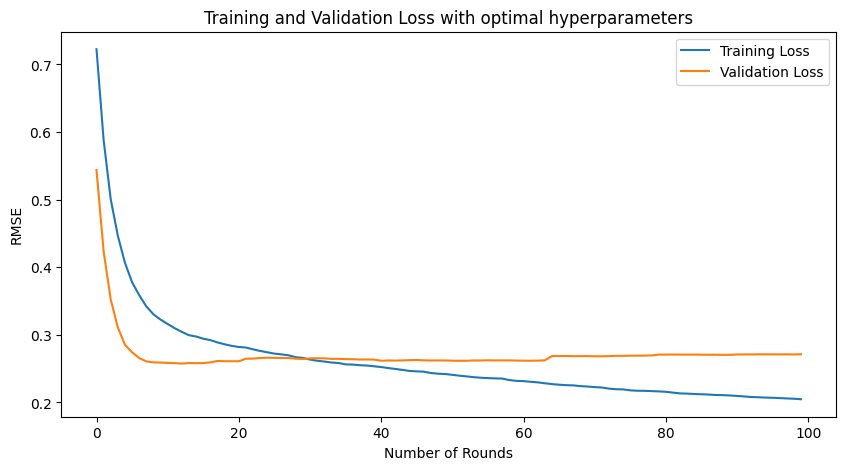


Train MAE: 0.13688290334800632
Train MSE: 0.041926473567640454
Train RMSE: 0.20475955061398346

Test MAE: 0.18649052716050055
Test MSE: 0.07355296654188989
Test RMAE: 0.27120650165858834


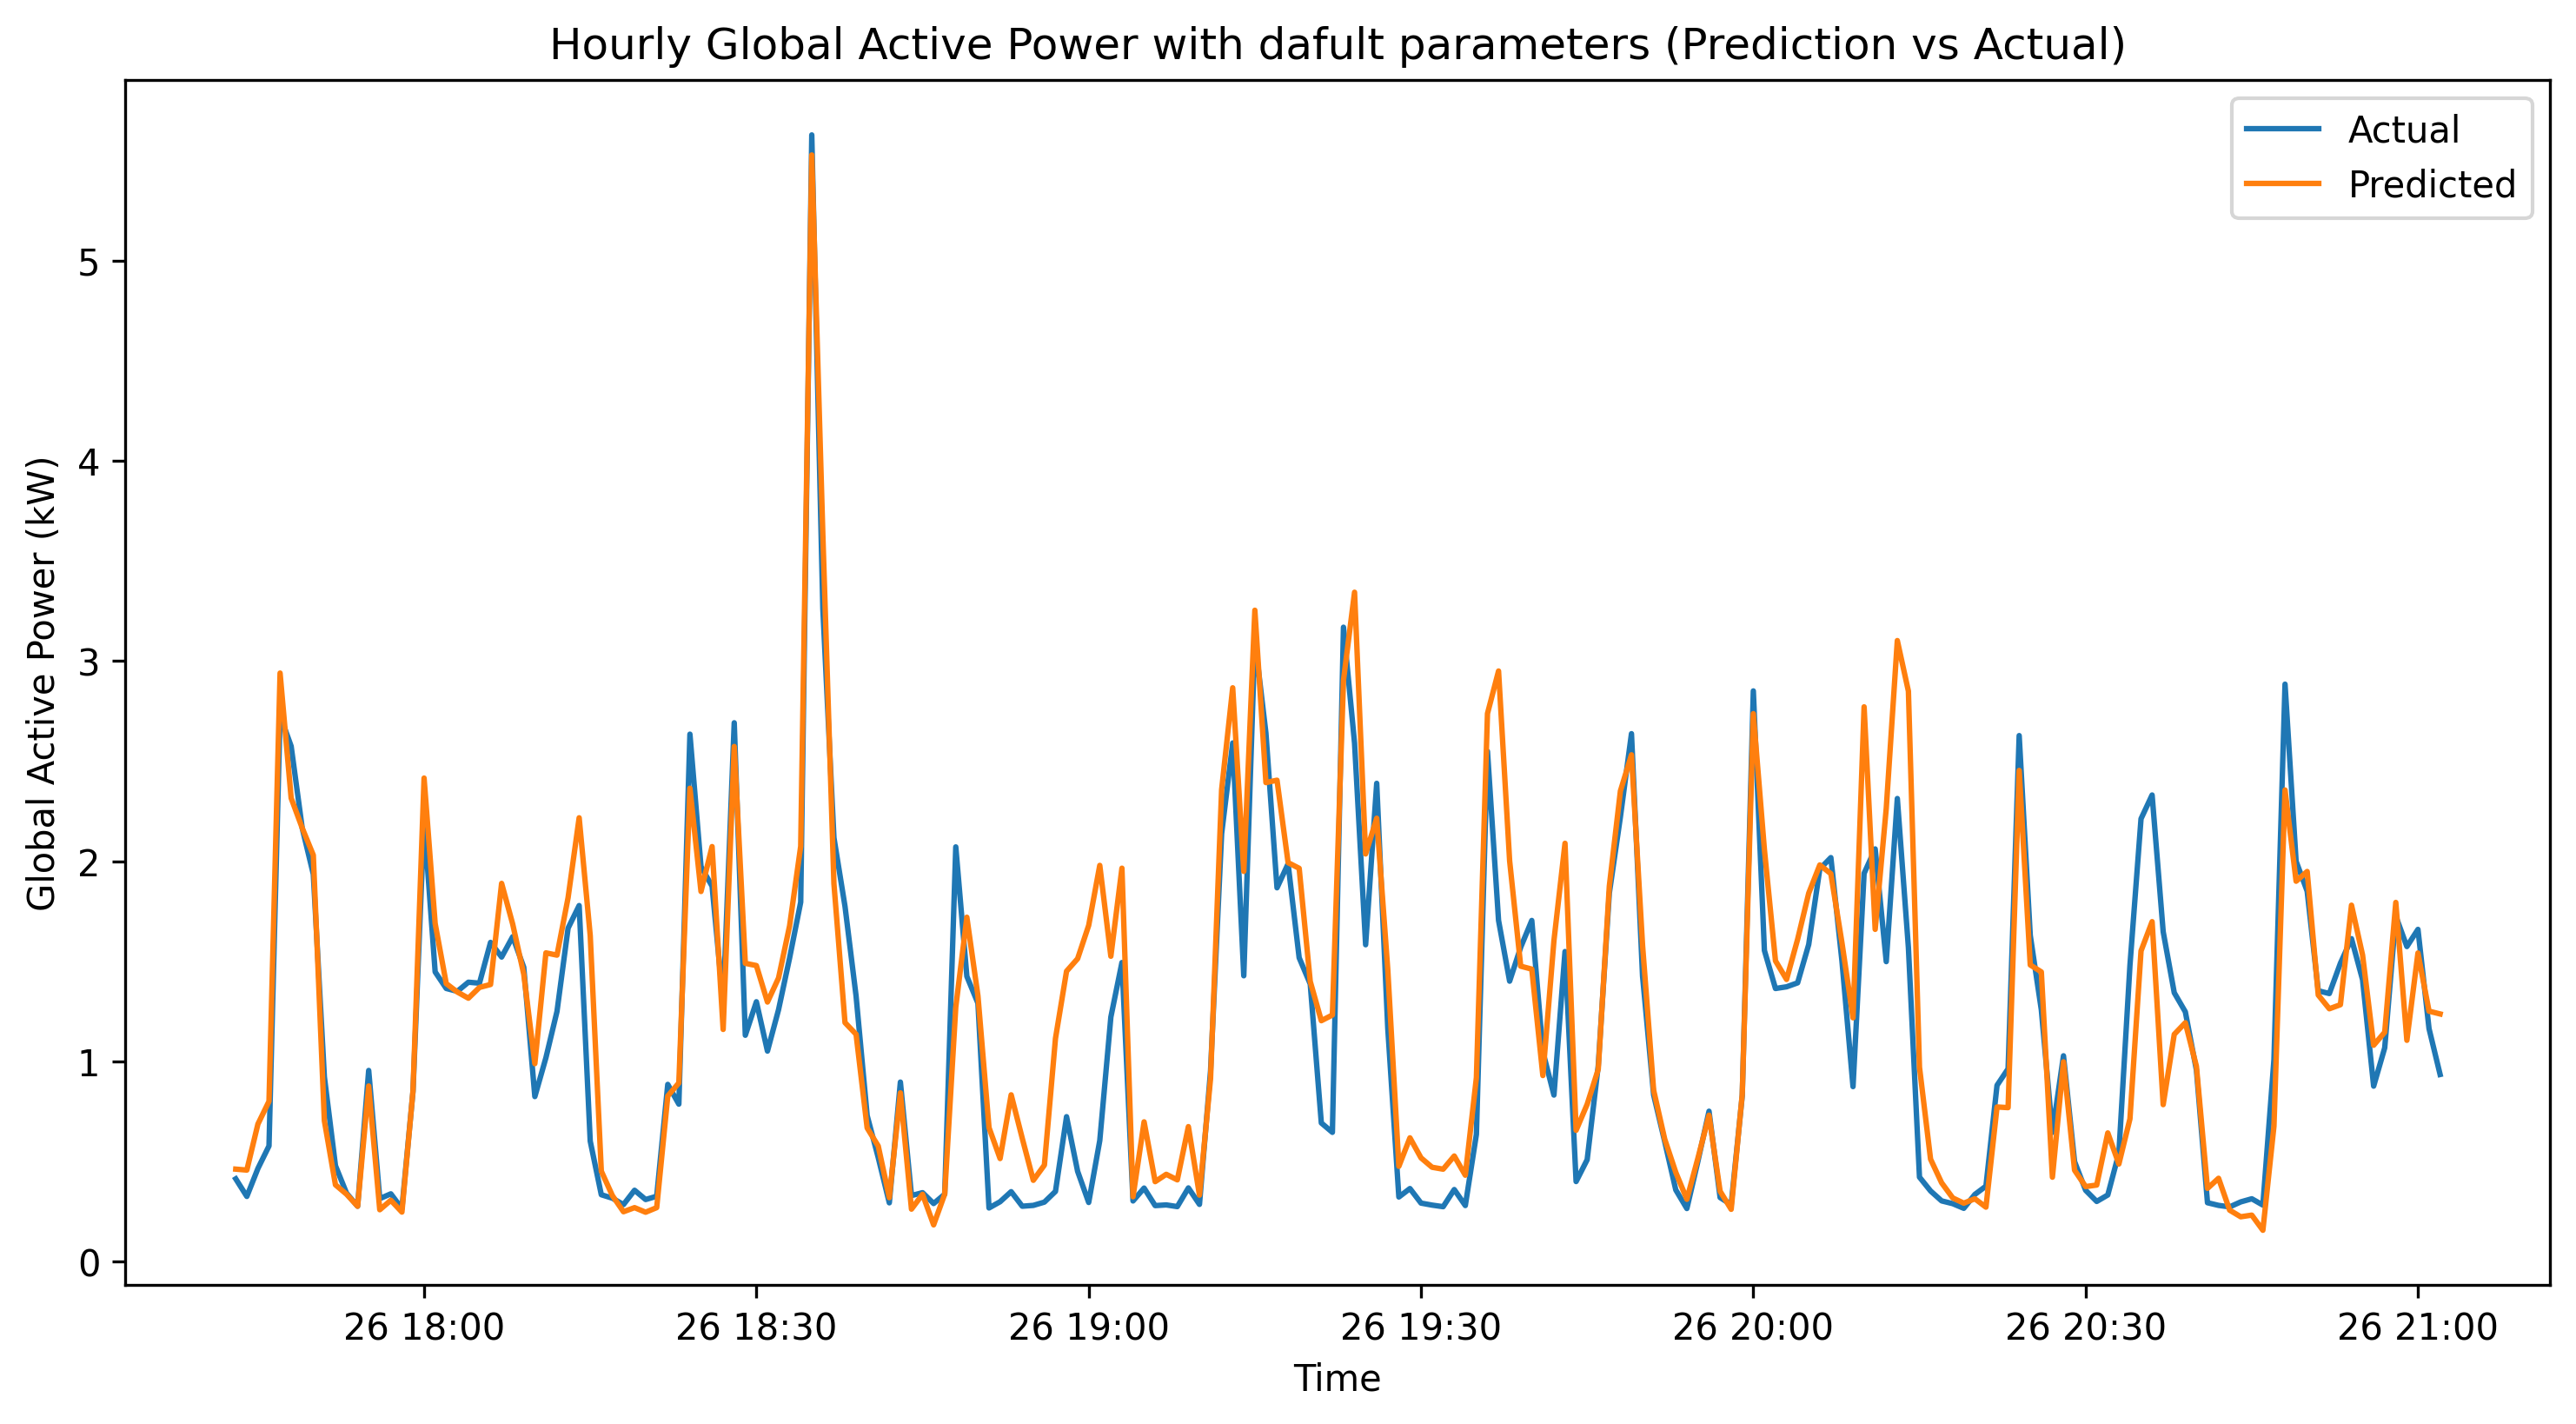

In [65]:
# XGboost model with default parameters
xgb_model = xgb.XGBRegressor()

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with optimal hyperparameters')
plt.legend()
plt.show()

# Predictions with the model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Calculate evaluation metrics
print('\nTrain MAE:', mean_absolute_error(y_train, train_predict))
print('Train MSE:', mean_squared_error(y_train, train_predict))
print('Train RMSE:',np.sqrt(mean_squared_error(y_train, train_predict)))
print('\nTest MAE:', mean_absolute_error(y_test, test_predict))
print('Test MSE:', mean_squared_error(y_test, test_predict))
print('Test RMAE:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Plot the graph Actual vs Prediction
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df.index[-200:], y_test[-200:], label='Actual')
plt.plot(df.index[-200:], test_predict[-200:], label='Predicted')
plt.title('Hourly Global Active Power with dafult parameters (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# Fine-tuing of hyperparameters

Parameters for Tree Booster

+ eta [default=0.3, alias: learning_rate]
Step size shrinkage used in update to prevent overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
range: [0,1]

+ gamma [default=0, alias: min_split_loss]
Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. Note that a tree where no splits were made might still contain a single terminal node with a non-zero score. range: [0,∞]

+ max_depth [default=6]
Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth. Beware that XGBoost aggressively consumes memory when training a deep tree. exact tree method requires non-zero value.range: [0,∞]

+ min_child_weight [default=1]
Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be. range: [0,∞]

+ max_delta_step [default=0]
Maximum delta step we allow each leaf output to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update. range: [0,∞]

+ subsample [default=1]
Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. range: (0,1]

+ sampling_method [default= uniform]
The method to use to sample the training instances.
uniform: each training instance has an equal probability of being selected. Typically set subsample >= 0.5 for good results.

  gradient_based: the selection probability for each training instance is proportional to the regularized absolute value of gradients (more specifically,). subsample may be set to as low as 0.1 without loss of model accuracy. Note that this sampling method is only supported when tree_method is set to hist and the device is cuda; other tree methods only support uniform sampling.

+ lambda [default=1, alias: reg_lambda]
L2 regularization term on weights. Increasing this value will make model more conservative.range: [0,∞]

+ alpha [default=0, alias: reg_alpha]
L1 regularization term on weights. Increasing this value will make model more conservative.range: [0,∞]

# Grid Search-1 for optimal hyperparameters

In [52]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameters
parameters_grid = {
    'n_estimators' : [1000, 1500, 2000],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1]
    }

# Set up Grid Search
grid_search = GridSearchCV(xgb_model, parameters_grid, scoring='neg_mean_squared_error', cv=7)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 2000, 'subsample': 0.5}
Best score:  -0.11778221721512273


# Grid Search-2 for optimal hyperparameters

In [61]:
# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameters
parameters_grid = {
    'base_score' : [0.2, 0.3, 0.5],
    'min_split_loss' : [1, 2, 3],
    'min_child_weight' : [2, 3, 5],
    'colsample_bytree': [0.3, 0.5, 0.8],
    'reg_lambda': [0, 2, 4],
    'reg_alpha' : [1, 3, 5]
    }

# Set up Grid Search
grid_search = GridSearchCV(xgb_model, parameters_grid, scoring='neg_mean_squared_error', cv=7)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'base_score': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 2, 'min_split_loss': 1, 'reg_alpha': 3, 'reg_lambda': 4}
Best score:  -0.12376089691033101


# XGBoost model with optimal hyperparameters

[0]	validation_0-rmse:1.22364	validation_1-rmse:1.00278
[100]	validation_0-rmse:0.65580	validation_1-rmse:0.49458
[200]	validation_0-rmse:0.45017	validation_1-rmse:0.32590
[300]	validation_0-rmse:0.37447	validation_1-rmse:0.27563
[400]	validation_0-rmse:0.34307	validation_1-rmse:0.26082
[500]	validation_0-rmse:0.32819	validation_1-rmse:0.25610
[600]	validation_0-rmse:0.32023	validation_1-rmse:0.25429
[700]	validation_0-rmse:0.31505	validation_1-rmse:0.25346
[800]	validation_0-rmse:0.31231	validation_1-rmse:0.25315
[864]	validation_0-rmse:0.31065	validation_1-rmse:0.25316


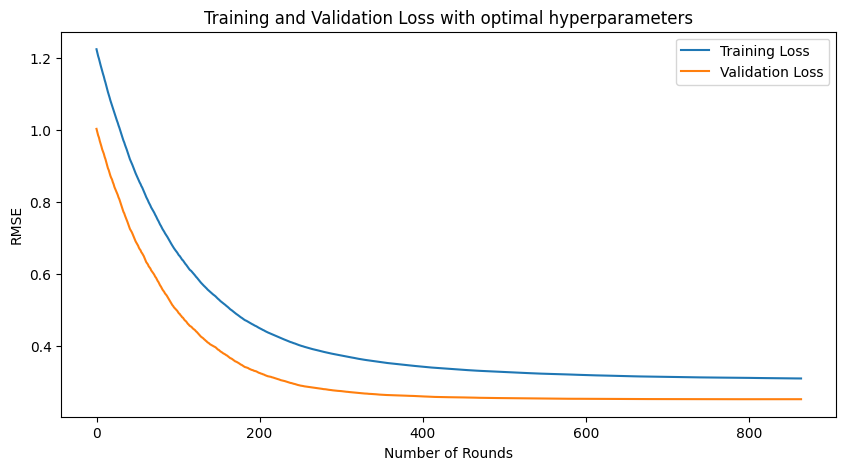


Train MAE: 0.20362269399686272
Train MSE: 0.09725086792654972
Train RMSE: 0.3118507141671311

Test MAE: 0.1692528495236304
Test MSE: 0.06405834194451646
Test RMSE: 0.2530974949392357


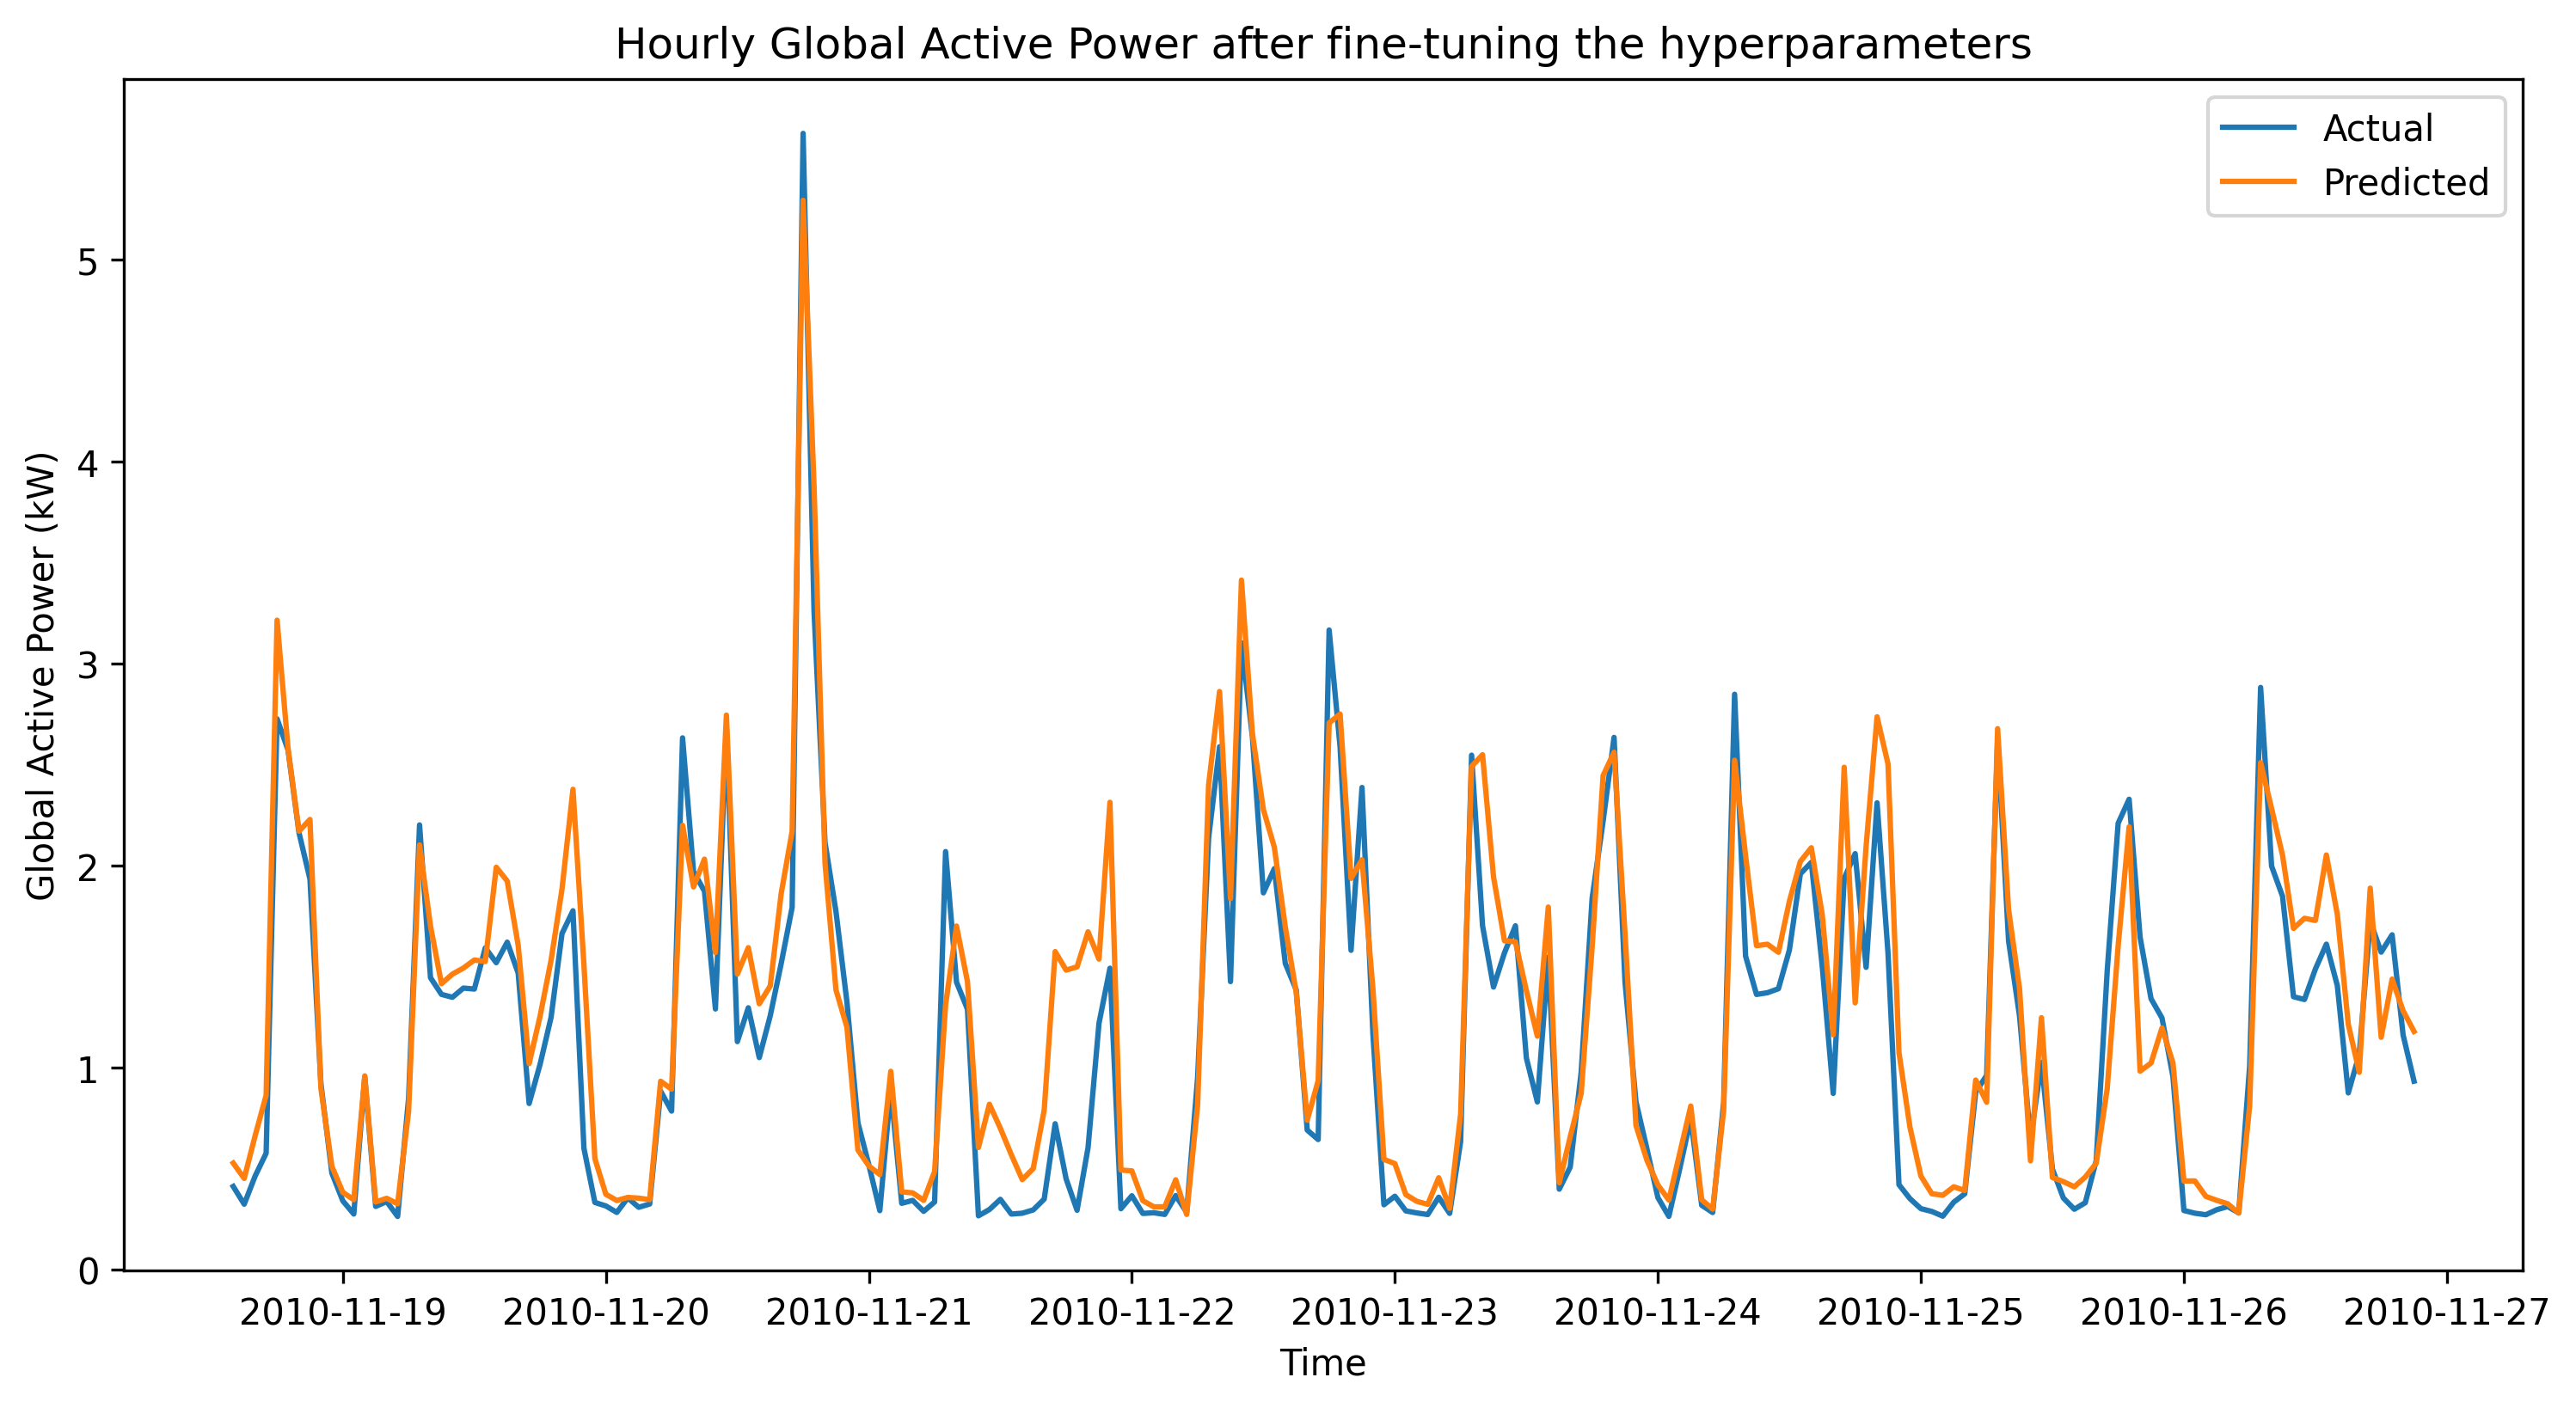

In [62]:
# Define the XGBoost model with differnt hyperparameters
xgb_model = xgb.XGBRegressor(booster='gbtree',
                             base_score=0.3,
                             n_estimators=2000,
                             early_stopping_rounds=50,
                             objective='reg:linear',
                             max_depth=5,              # [default=6] range: [0,∞]
                             learning_rate=0.01,       # [default=0.3] range: [0,1]
                             min_child_weight=2,       # [default=1] range: [0,∞]
                             subsample=0.5,            # [default=1] range: [0,1]
                             colsample_bytree=0.5,     # [default=1] range: [0,1]
                             min_split_loss=1,         # [default=0] range: [0,∞]
                             reg_alpha=3,              # [default=0] range: [0,∞]
                             reg_lambda=4)             # [default=1] range: [0,∞]

# Fit the XGboost model
history = xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

# Extract the evaluation results
evals_result = xgb_model.evals_result()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(evals_result['validation_0']['rmse'], label='Training Loss')
plt.plot(evals_result['validation_1']['rmse'], label='Validation Loss')
plt.xlabel('Number of Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation Loss with optimal hyperparameters')
plt.legend()
plt.show()

# Predictions with the fine-turned  model
train_predict = xgb_model.predict(X_train)
test_predict = xgb_model.predict(X_test)

# Calculate evaluation metrics
print('\nTrain MAE:', mean_absolute_error(y_train, train_predict))
print('Train MSE:', mean_squared_error(y_train, train_predict))
print('Train RMSE:',np.sqrt(mean_squared_error(y_train, train_predict)))
print('\nTest MAE:', mean_absolute_error(y_test, test_predict))
print('Test MSE:', mean_squared_error(y_test, test_predict))
print('Test RMSE:',np.sqrt(mean_squared_error(y_test, test_predict)))

# Plot the graph after fine-tuning the hyperparameters (Actual vs Prediction)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], test_predict[-200:], label='Predicted')
plt.title('Hourly Global Active Power after fine-tuning the hyperparameters')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()